In [1]:
# importing the dependencies
import numpy as np
import os
import os.path
import cv2
import glob
import imutils
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from operator import itemgetter
from collections import defaultdict
from sklearn.model_selection import train_test_split
import torch
torch.backends.cudnn.benchmark=True
torch.cuda.set_device(0)

In [2]:
#!pip install imutils

In [ ]:
# a function to take a path to an image and then segments the image into constituent letters and then return the letter

def image_segmentation(image_name):
    counter = 0
    # reading the image
    image = cv2.imread(image_name)

    # converting the image to grayscale
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # threshold to convert the image to pure black and white
    #thresh = cv2.threshold(gray, 0,255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]


    # find the contours (continous blob of pixels ) in the image 
    contours = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    contours = contours[0] if imutils.is_cv2() else contours[1]

    letter_image_regions = []

    # now loop through each of the letter in the image 
    for contour in contours:
        # get the rectangle that contains the contour
        x,y,w,h = cv2.boundingRect(contour)
        # compare the width and height of the contour to detect if it
        # has one letter or not
        if w/h >1.25:
            # this is too wide for a single letter
            continue
        elif w<3 or h<3:
            # this is a very small image probably a noise
            continue
        else:
        # this is a normal letter by itself
            letter_image_regions.append((x,y,w,h))

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]
        #constructing the name of the images 
        name = str(counter) + '.png'
        # incrementing the counter to store the next image 
        counter = counter +1
        return letter_image

In [2]:
Captchas_PATH = Path('labeled_captchas')

In [3]:
#list(Captchas_PATH.iterdir())

In [14]:
image_name = 'F85E9.png'
image_path = Captchas_PATH/image_name

In [17]:
cv2.__doc__

'Python wrapper for OpenCV.'

In [20]:
img = cv2.imread(str(image_path),1) #Read color image
img.shape

(150, 330, 3)

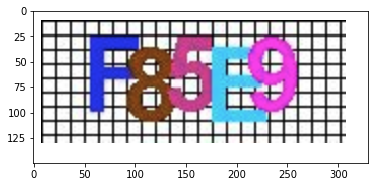

In [22]:
plt.imshow(img);

In [27]:
img1 = cv2.resize(img,(150,150))

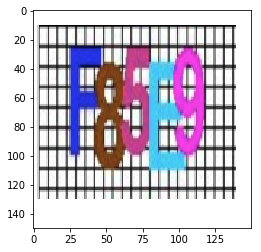

In [29]:
plt.imshow(img1);

In [30]:
contours = cv2.findContours(img1,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

error: /io/opencv/modules/imgproc/src/contours.cpp:199: error: (-210) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function cvStartFindContours_Impl


In [31]:
from PIL import Image

In [60]:
img2 = Image.open(image_path)

In [61]:
img2 = img2.convert("P")
his = img2.histogram()

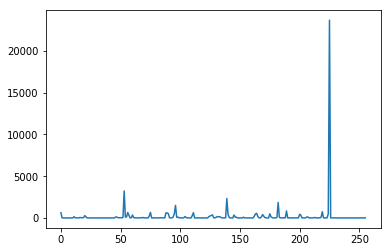

In [62]:
plt.plot(his);

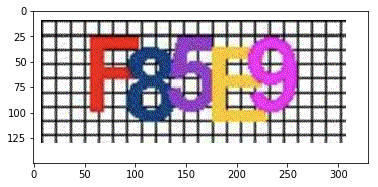

In [63]:
plt.imshow(img2)

In [64]:
colors = sorted(img2.getcolors(),key= itemgetter(0),reverse=True)[:7]

In [52]:
colors

[(23685, 225),
 (3226, 53),
 (2321, 139),
 (1854, 182),
 (1499, 96),
 (830, 189),
 (744, 219)]

In [71]:
img1.shape

(150, 150, 3)

In [86]:
colors = img1[2].tolist()
colors_freq = defaultdict(lambda:0)
for color in colors:
    colors_freq[color] += 1

TypeError: unhashable type: 'list'

In [77]:
a = Counter([1,2,1,1,2])

In [78]:
a

Counter({1: 3, 2: 2})

In [79]:
b = img1[2].tolist()

In [80]:
b

[[255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255, 255],
 [255, 255

## Net

In [9]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
CAPTCHA_LENGTH = 5

In [11]:
def ConvLayer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1))

In [12]:
class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=ConvLayer(ni, ni//2, ks=1)
        self.conv2=ConvLayer(ni//2, ni, ks=3)
        
    def forward(self, x): return x.add(self.conv2(self.conv1(x)))

In [13]:
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

In [14]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [ConvLayer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]


    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [ConvLayer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten()]
        self.layers = nn.Sequential(*layers)
        self.symbol_layers = nn.ModuleList()
        for i in range(CAPTCHA_LENGTH):
            linear_layer = nn.Sequential(nn.Linear(nf, num_classes),
                                         nn.Dropout(p=0.5),
                                         nn.ReLU()
                                        )
            self.symbol_layers.append(linear_layer)
         
    def forward(self, x): 
        x = self.layers(x)
        return [F.log_softmax(self.symbol_layers[i](x)) for i in range(CAPTCHA_LENGTH)]

In [15]:
def loss_function(output,target):
    loss_val = 0
    for i in range(CAPTCHA_LENGTH):
        #loss += np.sum((output[i]-target[i])**2)
        loss_val += F.nll_loss(output[i],target[:,i])
    return loss_val

## One-Hot

In [4]:
import string

In [5]:
SYMBOLS = list(string.ascii_uppercase + string.digits)
N_Classes = len(SYMBOLS)

In [6]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [7]:
label_encoder = LabelEncoder()
integer_encoded_symbs = label_encoder.fit_transform(SYMBOLS)
encoder = OneHotEncoder(sparse=False)
encoder.fit(integer_encoded_symbs.reshape(-1, 1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

In [8]:
encoder.transform(label_encoder.transform(['Z']).reshape(-1,1)).ravel()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1.])

In [9]:
ENCODED_SYMBOLS = {}
for symb in SYMBOLS:
    ENCODED_SYMBOLS[symb] = encoder.transform(label_encoder.transform([symb]).reshape(-1,1)).ravel()

In [9]:
ENCODED_SYMBOLS

{'0': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 '1': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 '2': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 '3': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 '4': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 '5': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 

## Categorical Encoding

In [3]:
import string

In [4]:
SYMBOLS = list(string.ascii_uppercase + string.digits)
N_Classes = len(SYMBOLS)

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
label_encoder = LabelEncoder()
label_encoder.fit(SYMBOLS)
stoi = {}
for symb in SYMBOLS:
    stoi[symb] = label_encoder.transform([symb])[0]

In [7]:
stoi

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35}

## Preprocessing

In [8]:
Captchas_PATH = Path('labeled_captchas')

In [16]:
X, y = [], []
for fname in Captchas_PATH.iterdir():
    img = cv2.imread(str(fname),1) #Read color image
    #img = img[10:130,:,:]
    #img = cv2.resize(img,(120,120))
    img = cv2.resize(img,(150,150))
    label = fname.name[:-4].upper()
    if len(label) == 5:
        X.append(img)
        y.append(label)
    else:
        print(label)

5A4B
B20EB0
27AA
D780
E1AEEF
FEE0
EC5F
9B07
E93E


It turns out that many images from the list were simply incorrectly labeled.

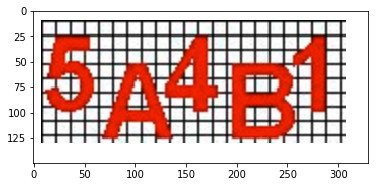

In [17]:
image_name = '5A4B.png'
image_path = Captchas_PATH/image_name
img2 = cv2.imread(str(image_path),1)
plt.imshow(img2);

In [17]:
y = [[ENCODED_SYMBOLS[symb] for symb in label] for label in y]

In [19]:
img = X[5][10:130,:,:]

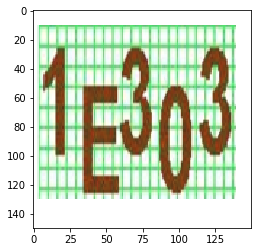

In [20]:
plt.imshow(X[5]);

In [18]:
# splitting the samples into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2,random_state = 1)

In [19]:
len(X_train), len(X_test)

(798, 200)

In [20]:
#Select validation set
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = .05,random_state = 1)

In [21]:
len(X_val)

40

In [22]:
from torch.utils.data import Dataset, DataLoader

In [23]:
from torchvision import transforms, datasets

In [24]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [25]:
X_train.shape

(758, 150, 150, 3)

In [26]:
means = [X_train[:,:,:,i].mean()/255 for i in range(3)]
stds = [X_train[:,:,:,i].std()/255 for i in range(3)]
means, stds

([0.7471896482544939, 0.7110150716539915, 0.6721225189553981],
 [0.32122075460556254, 0.35321328969183013, 0.3677937843705539])

In [27]:
preproc_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=means,std=stds),
    ])

In [28]:
X_train = [preproc_transforms(img) for img in X_train]
X_val = [preproc_transforms(img) for img in X_val]
X_test = [preproc_transforms(img) for img in X_test]

In [29]:
X_train, y_train = torch.stack(X_train), torch.LongTensor(y_train)
X_val, y_val = torch.stack(X_val), torch.LongTensor(y_val)
X_test, y_test = torch.stack(X_test), torch.LongTensor(y_test)

In [34]:
trfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(145),
    transforms.ToTensor()
])

In [30]:
train = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)

In [31]:
val = torch.utils.data.TensorDataset(X_val, y_val)

In [32]:
test = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


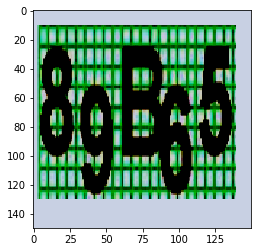

In [37]:
sample_data = next(iter(train_loader))
plt.imshow(sample_data[0][0].permute(1,2,0));

In [46]:
trfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(145)
])
trfm(X_train[0])

NameError: name 'trfm' is not defined

## Training

In [39]:
model = Darknet([1, 2, 4, 6, 3], num_classes=N_Classes, nf=32)
model.cuda()

Darknet(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (2): ResLayer(
      (conv1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stat

In [40]:
optimizer = optim.Adam(model.parameters(),lr=1e-2)

In [41]:
from torch.optim.lr_scheduler import LambdaLR

In [42]:
scheduler = LambdaLR(optimizer, lr_lambda= lambda epoch: 0.1**((epoch%300)/300))

In [43]:
def training(epoch,model,data_loader):
    for batch_idx , (data,target) in enumerate(data_loader):
        data, target = data.cuda(),target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output,target)
        
        loss.backward()
        scheduler.step()
        return loss

In [34]:
data , target = next(iter(train_loader))

In [35]:
target = target.cuda()

In [36]:
output = model(data.cuda())

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [37]:
output[0].size()

torch.Size([32, 36])

In [38]:
target[:,0].size()

torch.Size([32])

In [39]:
F.nll_loss(output[0],target[:,0]) 

tensor(3.6781, device='cuda:0')

In [40]:
F.nll_loss(output[1],target[:,1])

tensor(3.6983, device='cuda:0')

In [41]:
loss = 0
for i in range(CAPTCHA_LENGTH):
    loss += F.nll_loss(output[i],target[:,i])
loss

tensor(18.3001, device='cuda:0')

In [42]:
torch.sqrt(loss)

tensor(4.2779, device='cuda:0')

In [45]:
model.train()
for epoch in range(1,5001):
    train_loss = training(epoch,model,train_loader)
    print("\rEpoch: {}, Train loss: {}" .format(epoch,train_loss),end='')
    if epoch % 100 == 0:
        with torch.no_grad():
            model.eval()
            output = model(val.tensors[0].cuda())
            val_loss = loss_function(output,val.tensors[1].cuda())
            print("\rEpoch: {}, Train loss: {}, Val loss: {}" .format(epoch,train_loss,val_loss))
        model = model.train()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 100, Train loss: 18.57111930847168, Val loss: 18.10430335998535
Epoch: 200, Train loss: 18.596981048583984, Val loss: 18.091167449951172
Epoch: 300, Train loss: 18.297157287597656, Val loss: 18.094074249267578
Epoch: 400, Train loss: 18.55653953552246, Val loss: 18.095781326293945
Epoch: 500, Train loss: 18.616579055786133, Val loss: 18.096420288085938
Epoch: 600, Train loss: 18.547039031982422, Val loss: 18.096782684326172
Epoch: 700, Train loss: 18.478548049926758, Val loss: 18.096925735473633
Epoch: 800, Train loss: 18.602184295654297, Val loss: 18.096982955932617
Epoch: 900, Train loss: 18.624502182006836, Val loss: 18.097000122070312
Epoch: 1000, Train loss: 18.551969528198242, Val loss: 18.097007751464844
Epoch: 1100, Train loss: 18.604543685913086, Val loss: 18.097007751464844
Epoch: 1200, Train loss: 18.61077117919922, Val loss: 18.097007751464844
Epoch: 1300, Train loss: 18.522449493408203, Val loss: 18.097007751464844
Epoch: 1400, Train loss: 18.695581436157227, Val lo

In [38]:
model.train()
for epoch in range(1,501):
    train_loss = training(epoch,model,train_loader)
    print("\rEpoch: {}, Train loss: {}" .format(epoch,train_loss),end='')

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 500, Train loss: 18.461179733276367

In [41]:
with torch.no_grad():
    model.eval()
    test_loss = 0
    count = 0
    for batch_idx , (data,target) in enumerate(test_loader):
        count += 1
        data, target = data.cuda(),target.cuda()
        output = model(data)
        test_loss += loss_function(output,target)
print("Test loss: {}" .format(test_loss/count))

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test loss: 17.901695251464844


In [72]:
test_sample = next(iter(test_loader))
data , target = test_sample
test_img, label = data[4].permute(1,2,0).numpy(),target[4].numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


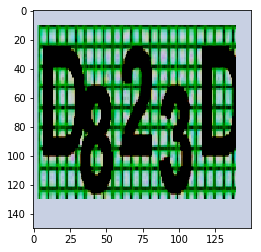

In [73]:
plt.imshow(test_img);

In [74]:
with torch.no_grad():
    model.eval()
    output = model(data[4][None].cuda())

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [75]:
[output[i].data.max(dim=1)[1] for i in range(CAPTCHA_LENGTH)]

[tensor([ 4], device='cuda:0'),
 tensor([ 32], device='cuda:0'),
 tensor([ 34], device='cuda:0'),
 tensor([ 8], device='cuda:0'),
 tensor([ 29], device='cuda:0')]

In [59]:
ENCODED_SYMBOLS

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35}

In [55]:
a = output[4].data.max(dim=1,keepdim=True)[1]

In [58]:
np.array(a)

array([[25]])

In [47]:
torch.save(model, 'model.pt')

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Darknet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ResLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [33]:
model = torch.load('model.pt')